In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define a simple CNN-based policy network
class SimplePolicyNet(nn.Module):
    def __init__(self):
        super(SimplePolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(20, 32, kernel_size=3, stride=1, padding=1)  # Input has 20 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 21 * 21, 128)
        self.fc2 = nn.Linear(128, 2)  # Output 2-dim control signal (e.g., steering and throttle)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (21, 21))  # Adaptive pooling to reduce size
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and set it to evaluation mode
model = SimplePolicyNet()
model.eval()

# Example input: A batch with a single 20-channel (5 RGBD frames) input of size 84x84
input_image = torch.randn(1, 20, 84, 84)  # Replace this with your actual input


In [19]:
attr_to_visualize.shape

(1, 84, 84)

In [ ]:
np.swapaxes

attr_to_visualize (84, 84, 1)


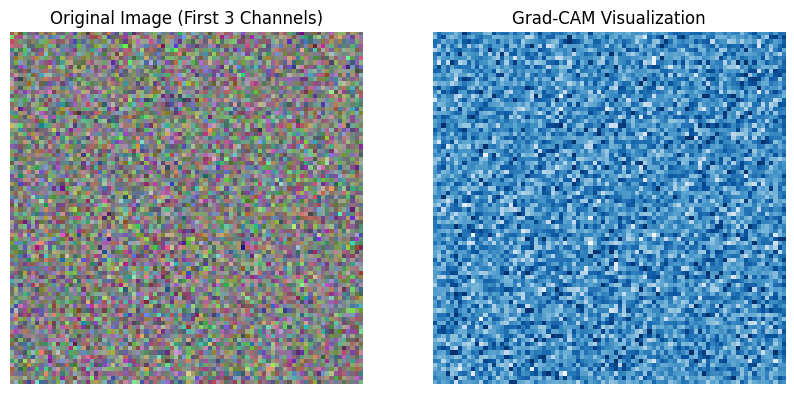

In [25]:
from captum.attr import LayerGradCam
from captum.attr import visualization as viz
import numpy as np

# Create a LayerGradCam object for the target convolutional layer
layer_gc = LayerGradCam(model, model.conv2)

# Choose the target output (e.g., 0 for the first control output)
target_index = 0

# Compute the Layer Grad-CAM
attributions = layer_gc.attribute(input_image, target=target_index)

# Convert the attributions to numpy for visualization
# Since the output of Grad-CAM is already in (N, C, H, W), we need to squeeze and take the first channel for visualization
attributions = attributions.squeeze().cpu().detach().numpy()  # Resulting shape should be (C, H, W)

attr_to_visualize = attributions

attr_to_visualize = attr_to_visualize[..., None]

# Visualize Grad-CAM for a selected channel (e.g., the first channel of the output from the convolution)
# attr_to_visualize = attributions[0]  # Choose one channel (H, W) for visualization

# Normalize attributions for visualization
attr_to_visualize = (attr_to_visualize - np.min(attr_to_visualize)) / (np.max(attr_to_visualize) - np.min(attr_to_visualize) + 1e-8)

# Show Original RGB Image (first 3 channels)
original_image = input_image[0, :3].permute(1, 2, 0).cpu().detach().numpy()
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())  # Normalize

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(original_image)
ax[0].axis('off')
ax[0].set_title('Original Image (First 3 Channels)')

print("attr_to_visualize", attr_to_visualize.shape)
# Visualize Grad-CAM heatmap using Captum's visualization utilities
viz.visualize_image_attr(attr_to_visualize, original_image, method="heat_map", plt_fig_axis=(fig, ax[1]), use_pyplot=False)
ax[1].axis('off')
ax[1].set_title('Grad-CAM Visualization')

plt.show()
